In this notebook we present sparse relaxations to binary random variables. These are based on relaxing random outcomes from $\{0, 1\}$ to $[0, 1]$ while giving $\{0\}$ and $\{1\}$ discrete treatment. This enables a differentiable reparameterisation that is an unbiased alternative to the biased straight-through estimator.

In [1]:
%load_ext autoreload
%autoreload 2

Helper code to plot
* samples
* pdf
* cdf
for distributions over $(\text{lower}, \text{upper}) \supset (0, 1)$

In [2]:
def plot(dist, n=10000, bins=40, step=0.001, lower=-0.1, upper=1.1, masses=[], vlines=[0., 1.], color='blue', title='summary'):       
    
    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.suptitle(title)
            
    # samples
    plt.subplot(1, 3, 1)
    x = dist.sample(sample_shape=torch.Size([n])).reshape(-1).numpy()
    _ = plt.hist(x, bins, density=False, color=color)     
    for value in vlines:
        plt.axvline(value, color='black', linestyle='dashed', linewidth=1)
    plt.xlim(left=lower)
    plt.xlim(right=upper)
    plt.title("samples")
    
    # pdf
    plt.subplot(1, 3, 2) 
    x = np.arange(lower + step, upper, step)        
    y = np.exp(dist.log_prob(torch.from_numpy(x).float()).numpy())            
    plt.plot(x, y, color=color, linestyle='', marker='.', markersize=0.2)  
    for value in vlines:            
        plt.axvline(value, color='black', linestyle='dashed', linewidth=1)    
    plt.xlim(left=lower)
    plt.xlim(right=upper)
    if masses:
        y_masses = np.exp(dist.log_prob(torch.from_numpy(np.array(masses)).float()).numpy())
        plt.bar(masses, y_masses, width=0.05, align='center', color=color)
#        plt.bar(masses, [dist.p0.numpy(), dist.p1.numpy()], width=0.05, align='center', color=color)
    plt.title("pdf")

    # cdf
    plt.subplot(1, 3, 3)        
    y = dist.cdf(torch.from_numpy(x).float()).numpy()
    plt.plot(x, y, color=color, linestyle='', marker='.', markersize=0.2)            
    for value in vlines:            
        plt.axvline(value, color='black', linestyle='dashed', linewidth=1)
    plt.xlim(left=lower)
    plt.xlim(right=upper)
    if masses:
        y_masses = dist.cdf(torch.from_numpy(np.array(masses)).float()).numpy()
        plt.plot(masses, y_masses, color=color, linestyle='', marker='x', markersize=5)        
    plt.title("cdf")


In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.distributions import Uniform
from sparsedists.kumaraswamy import Kumaraswamy
from sparsedists.d01c01 import Stretched, Truncated01, Rectified01, MixtureD01C01

# Stretch and Rectify

Let's start with a Kumaraswamy distribution

In [4]:
a, b = 0.5, 0.5
K = Kumaraswamy(a=torch.full([1], a), b=torch.full([1], b))

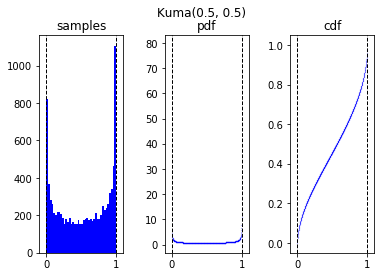

In [5]:
plot(K, title=f"Kuma({a}, {b})")

We can then stretch it to a support larger than $(0, 1)$

In [6]:
SK = Stretched(K)

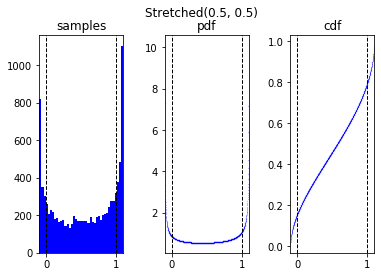

In [7]:
plot(SK, title=f"Stretched({a}, {b})")

We can also truncate this stretched distribution back to $(0, 1)$, this requires renormalising the truncated curve to obtain a proper pdf, which we do. 

In [8]:
TSK = Truncated01(SK)

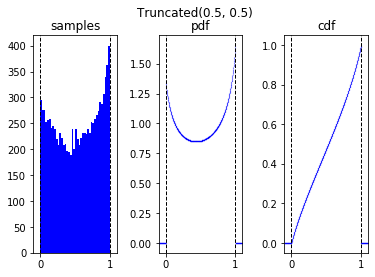

In [9]:
plot(TSK, title=f"Truncated({a}, {b})")

Instead of truncating, we can *rectify* the stretched distribution using a hard-sigmoid. This is quite different. Truncation simply disregards samples outside $(0, 1)$, whereas rectification maps those samples to either $0$ or $1$. The result is a distribution function that mixes a delta function at $0$, another at $1$, and a pdf over $(0, 1)$. The weight of $\delta(x)$ is given by how much of the stretched curve covers the negative support. Similarly, the weight of $\delta(1-x)$ is given by how much of the stretched curve covers the support beyond $1$.
Finally, the continuous distribution in the middle, i.e. over $(0, 1)$, is a density obtained by renormalising the truncated curve (see why we needed that?!). 

In [10]:
RSK = Rectified01(SK)

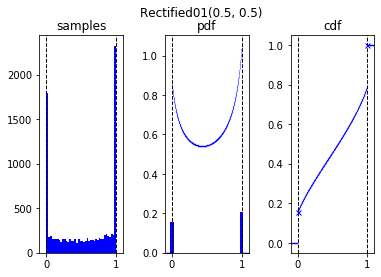

In [11]:
plot(RSK, masses=[0., 1.], title=f"Rectified01({a}, {b})")

This abstract is very powerful! For as long as we know the cdf and the inverse cdf of a distribution that includes $(0, 1)$ in its support, we can obtain rectified distributions as presented above. 

Torch has efficient and differentiable algorithms for the Gaussian cdf and inverse cdf, thus we can use a standard Normal, for example, as base for rectification. 

In [12]:
from torch.distributions import Normal

If we truncated to $(0, 1)$ a Gaussian centered at $0.5$ with a large variance, we will see that the pdf is close to uniform.

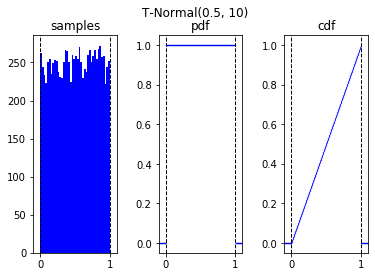

In [13]:
plot(Truncated01(Normal(torch.full([1], 0.5), torch.full([1], 10))), title="T-Normal(0.5, 10)")

Let's rectify $\mathcal N(0.5, 10)$ and see what happens.

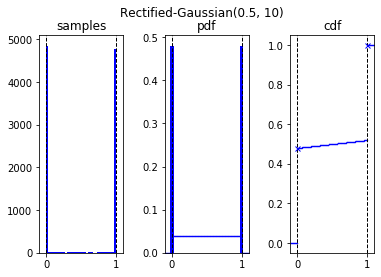

In [14]:
RN = Rectified01(Normal(torch.full([1], 0.5), torch.full([1], 10)))
plot(RN, masses=[0., 1.], title="Rectified-Gaussian(0.5, 10)")

This is very close to assigning $0.5$ to each point mass with some negligible mass roughly uniformly spread over $(0,1)$. That looks like a cool prior, doesn't it?

Here is another way to get similar distribution, without the complicated Gaussian cdf and icdf.

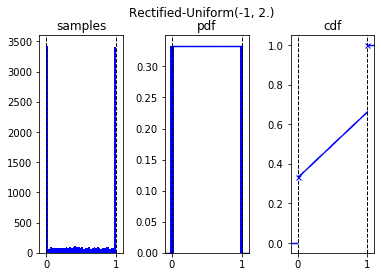

In [15]:
RU = Rectified01(Uniform(torch.full([1], -1.), torch.full([1], 2.)))
plot(RU, masses=[0., 1.], title="Rectified-Uniform(-1, 2.)")

and note that in this case the point masses depend on how far we push the support of the Uniform. We could even have the masses differ in importance.

# Direct Parameterisation

Another way to obtain sparse relaxations is to directly parameterise a mixture. Something like:

\begin{align}
    p(x|a, f) &= a_0 \delta(x) + a_1 \delta(1-x) + \underbrace{(1 - a_0 - a_1)}_{\overset{\text{def}}{=} a_c} f(x) \mathbb 1_{(0,1)}(x)
\end{align}

where

* $f(x)$ is a *properly normalised* density over $(0, 1)$
* $\mathbb 1_{(0,1)}(x)$ is the indicator function

Note that *rectified distributions* are members of this family too, howerver, in that case $a_0$, $a_1$, $a_c$, and $f(x)$ all depend on how mass distributes over some support $(l, u) \supset (0, 1)$ as governed by a base density $\pi(x)$. In that case we have 

\begin{align}
a_0 &= \int_{-\infty}^0 \pi(x) \text{d}x \\
a_1 &= \int_{1}^\infty \pi(x) \text{d}x \\
a_c &= \int_{0}^1 \pi(x) \text{d}x \\
f(x) &= \frac{\pi(x)\mathbb 1_{(0,1)}(x)}{a_c}
\end{align}

Let's start by mixing deltas with uniform and controlling the weights of the deltas to get the shape we want:

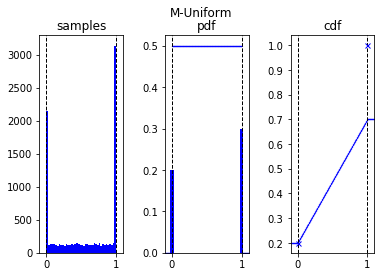

In [16]:
MU = MixtureD01C01(
    cont=Uniform(torch.zeros(1), torch.ones(1)), 
    probs=torch.from_numpy(np.array([0.2, 0.3, 0.5])).float()
)
plot(MU, masses=[0., 1.], title="M-Uniform")

We can also mix with a Kumaraswamy. One big difference here is that the Kumaraswamy has shapes that promote getting arbitrarily close to $0$ or $1$ without ever touching those values (note how the pdf will attain large values close to $0$ and $1$ in the example below).

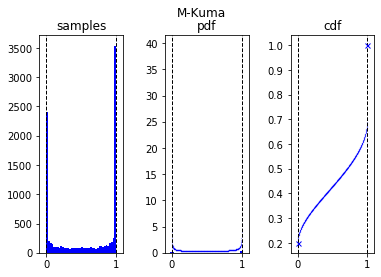

In [17]:
MK = MixtureD01C01(
    cont=Kumaraswamy(a=torch.full([1], 0.5), b=torch.full([1], 0.5)),
    probs=torch.from_numpy(np.array([0.2, 0.3, 0.5])).float()
)
plot(MK, masses=[0., 1.], title="M-Kuma")

# KL Divergence

Let's consider two distributions in this family of sparse relaxations to binary distributions

\begin{align}
p(x|a, f) &= a_0 \delta(x) + a_1 \delta(1-x) + \underbrace{(1 - a_0 - a_1)}_{\overset{\text{def}}{=} a_c} f(x) \mathbb 1_{(0,1)}(x) \\
q(x|b, g) &= b_0 \delta(x) + b_1 \delta(1-x) + \underbrace{(1 - b_0 - b_1)}_{\overset{\text{def}}{=} b_c} g(x) \mathbb 1_{(0, 1)}(x) 
\end{align}

and compute the KL between them. 


Then 
\begin{align}
    &\text{KL}(p(x|a, f) || q(x|b, g)) \\
    &= a_0 \log \frac{a_0}{b_0} \\
    &+ a_1 \log \frac{a_1}{b_1} \\
    &+ a_c \log \frac{a_c}{b_c} \\
    &+ a_c \int_0^1 f(x) \log \frac{f(x)}{g(x)}  \text{d}x    
\end{align}
    

We have some helper code to debug KL/entropy implementations. The idea is to compare to simpler MC estimates.

In [19]:
from sparsedists.utils import mc_kl

When training our models, we generally estimate KL with a single sample, but we do so in mini-batches full of training instances and over many epochs. Thus I am going to get a sample mean of the single-sample estimate based on $1000$ simulations.

In [20]:
mc_kl(MK, MU, 100000), np.mean([MK.kl(MU).numpy() for _ in range(1000)])

(tensor([0.1138]), 0.10180048)

Also, we could have exploited the fact that we know the Kumaraswamy entropy:

In [21]:
mc_kl(MK, MU, 100000), np.mean([MK.kl(MU, exact_entropy=True).numpy() for _ in range(1000)])

(tensor([0.1114]), 0.113705635)

Recall I pointed out that rectified distributions are in the same family, we can estimate KL for them too:

In [22]:
mc_kl(RSK, RN, 100000), np.mean([RSK.kl(RN).numpy() for _ in range(1000)])

(tensor([1.4211]), 1.4249692)

In [23]:
mc_kl(RSK, RU, 100000), np.mean([RSK.kl(RU).numpy() for _ in range(1000)])

(tensor([0.2050]), 0.20300686)

And we can even mix and match ;)

In [24]:
mc_kl(RSK, MK, 100000), np.mean([RSK.kl(MK).numpy() for _ in range(1000)])

(tensor([0.0921]), 0.08941071)

In [25]:
mc_kl(RSK, MU, 100000), np.mean([RSK.kl(MU).numpy() for _ in range(1000)])

(tensor([0.0492]), 0.043565635)